In [5]:
import pandas as pd

pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline


In [482]:
data = pd.read_csv('Data/positive_combined.csv')
data.head()

class                                           complain
0  not related  Hard to have a personal life because Operation...
1  not related  There are no benefits, no maternity leave. You...
2  not related  lot of turnover in the front desk department. ...
3  not related                       I have nothing bad to report
4  not related  Work hours can be long even if working from ho...

In [483]:
data['complain'] = data.complain.apply(lambda x: x.lower())

In [484]:
data.head()

class                                           complain
0  not related  hard to have a personal life because operation...
1  not related  there are no benefits, no maternity leave. you...
2  not related  lot of turnover in the front desk department. ...
3  not related                       i have nothing bad to report
4  not related  work hours can be long even if working from ho...

# word2vec modelling

In [485]:
import gensim

In [486]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    sentences = data.complain.values.tolist()
    for sentence in sentences:
    
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))    
    #return corpus

corpus = list(build_corpus(data))              


In [487]:
len(corpus)

300

In [488]:
#corpus[0]

In [489]:
vecsize = 200
#not bad
#model = word2vec.Word2Vec(corpus, size=200, window=2, min_count=5, negative=1, workers = 4)#workers CPUs
model = word2vec.Word2Vec(corpus, size=100, window=2, min_count=5, negative=0, sample = 1e-5)#workers CPUs
#model.wv['slave']

In [490]:
len(model.wv.vocab)

551

In [491]:
model.wv.similarity('work', 'good')

-0.043022286

In [492]:
model.wv.similarity('work', 'bad')

0.12408264

In [493]:
model.wv.most_similar(positive=['work']) 

[('insurance', 0.2882722318172455),
 ('set', 0.2584960162639618),
 ('working', 0.24791713058948517),
 ('place', 0.24742819368839264),
 ('things', 0.2456427663564682),
 ('in', 0.23844413459300995),
 ('started', 0.23440474271774292),
 ('effort', 0.22337999939918518),
 ('why', 0.22136878967285156),
 ('short', 0.22062362730503082)]

In [494]:
from sklearn.decomposition import PCA
import seaborn as sns

In [495]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

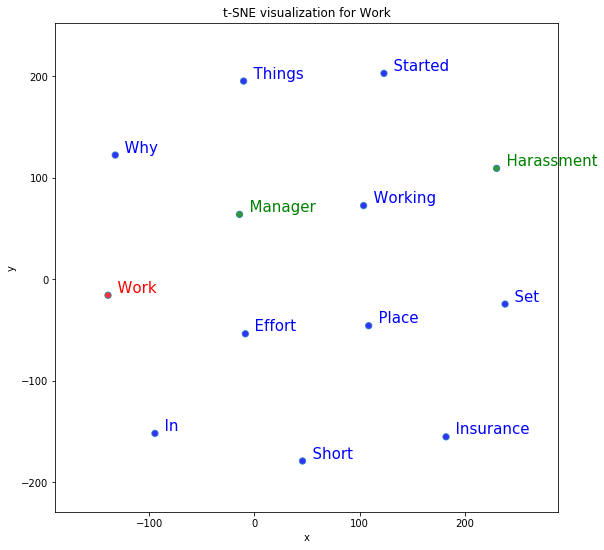

In [499]:
tsnescatterplot(model, 'work', ['harassment','manager'])
#try to do it interactive

# Word cloud

## from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

In [500]:
word_vectors =  model.wv

In [501]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [502]:
Z = model.wv.syn0;

print(Z[0].shape)
Z[0]

(100,)


/media/windows/Users/Afrokate/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


array([-0.00289489,  0.00097407,  0.00027363,  0.00373982, -0.00325024,
       -0.00447694, -0.00011712, -0.00449226, -0.00407385,  0.00026525,
       -0.00398091,  0.00473962, -0.00106567, -0.0000473 , -0.0038135 ,
        0.00456982, -0.00132297, -0.00216652,  0.00355407, -0.00393913,
        0.00249715,  0.00083849, -0.00270447, -0.00166263, -0.0017507 ,
       -0.00441083,  0.00335463, -0.00240152, -0.0041349 ,  0.00214249,
        0.00071679, -0.00456587,  0.00156016, -0.00310738,  0.00377692,
        0.00419904,  0.0016429 , -0.00186219,  0.00275368,  0.00072638,
       -0.00066678,  0.0022015 , -0.00031557,  0.00291883, -0.00412056,
        0.0027194 , -0.0035384 , -0.0002284 , -0.00328929,  0.00257913,
        0.00079367,  0.00093151,  0.00328198, -0.00258604,  0.00146684,
        0.00272118,  0.0021246 , -0.00267578, -0.00328783, -0.00225268,
        0.00344603,  0.0026731 ,  0.00418519,  0.00061822,  0.00475402,
       -0.00018777,  0.00214139,  0.00419385, -0.00034968, -0.00

In [503]:
centers, clusters = clustering_on_wordvecs(Z, 6);
centroid_map = dict(zip(model.wv.index2word, clusters));

In [504]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

#Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

#Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster num' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]

#A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [505]:
 ccc = [KDTree(Z).query(np.reshape(x, (1, -1)), k=100) for x in centers];

In [506]:
len((ccc[1][1][0]))

100

In [507]:
top_words = get_top_words(model.wv.index2word, 100, centers, Z);

In [508]:
top_words.columns

Index(['Cluster num0', 'Cluster num1', 'Cluster num2', 'Cluster num3',
       'Cluster num4', 'Cluster num5'],
      dtype='object')

In [509]:
#!pip install wordcloud

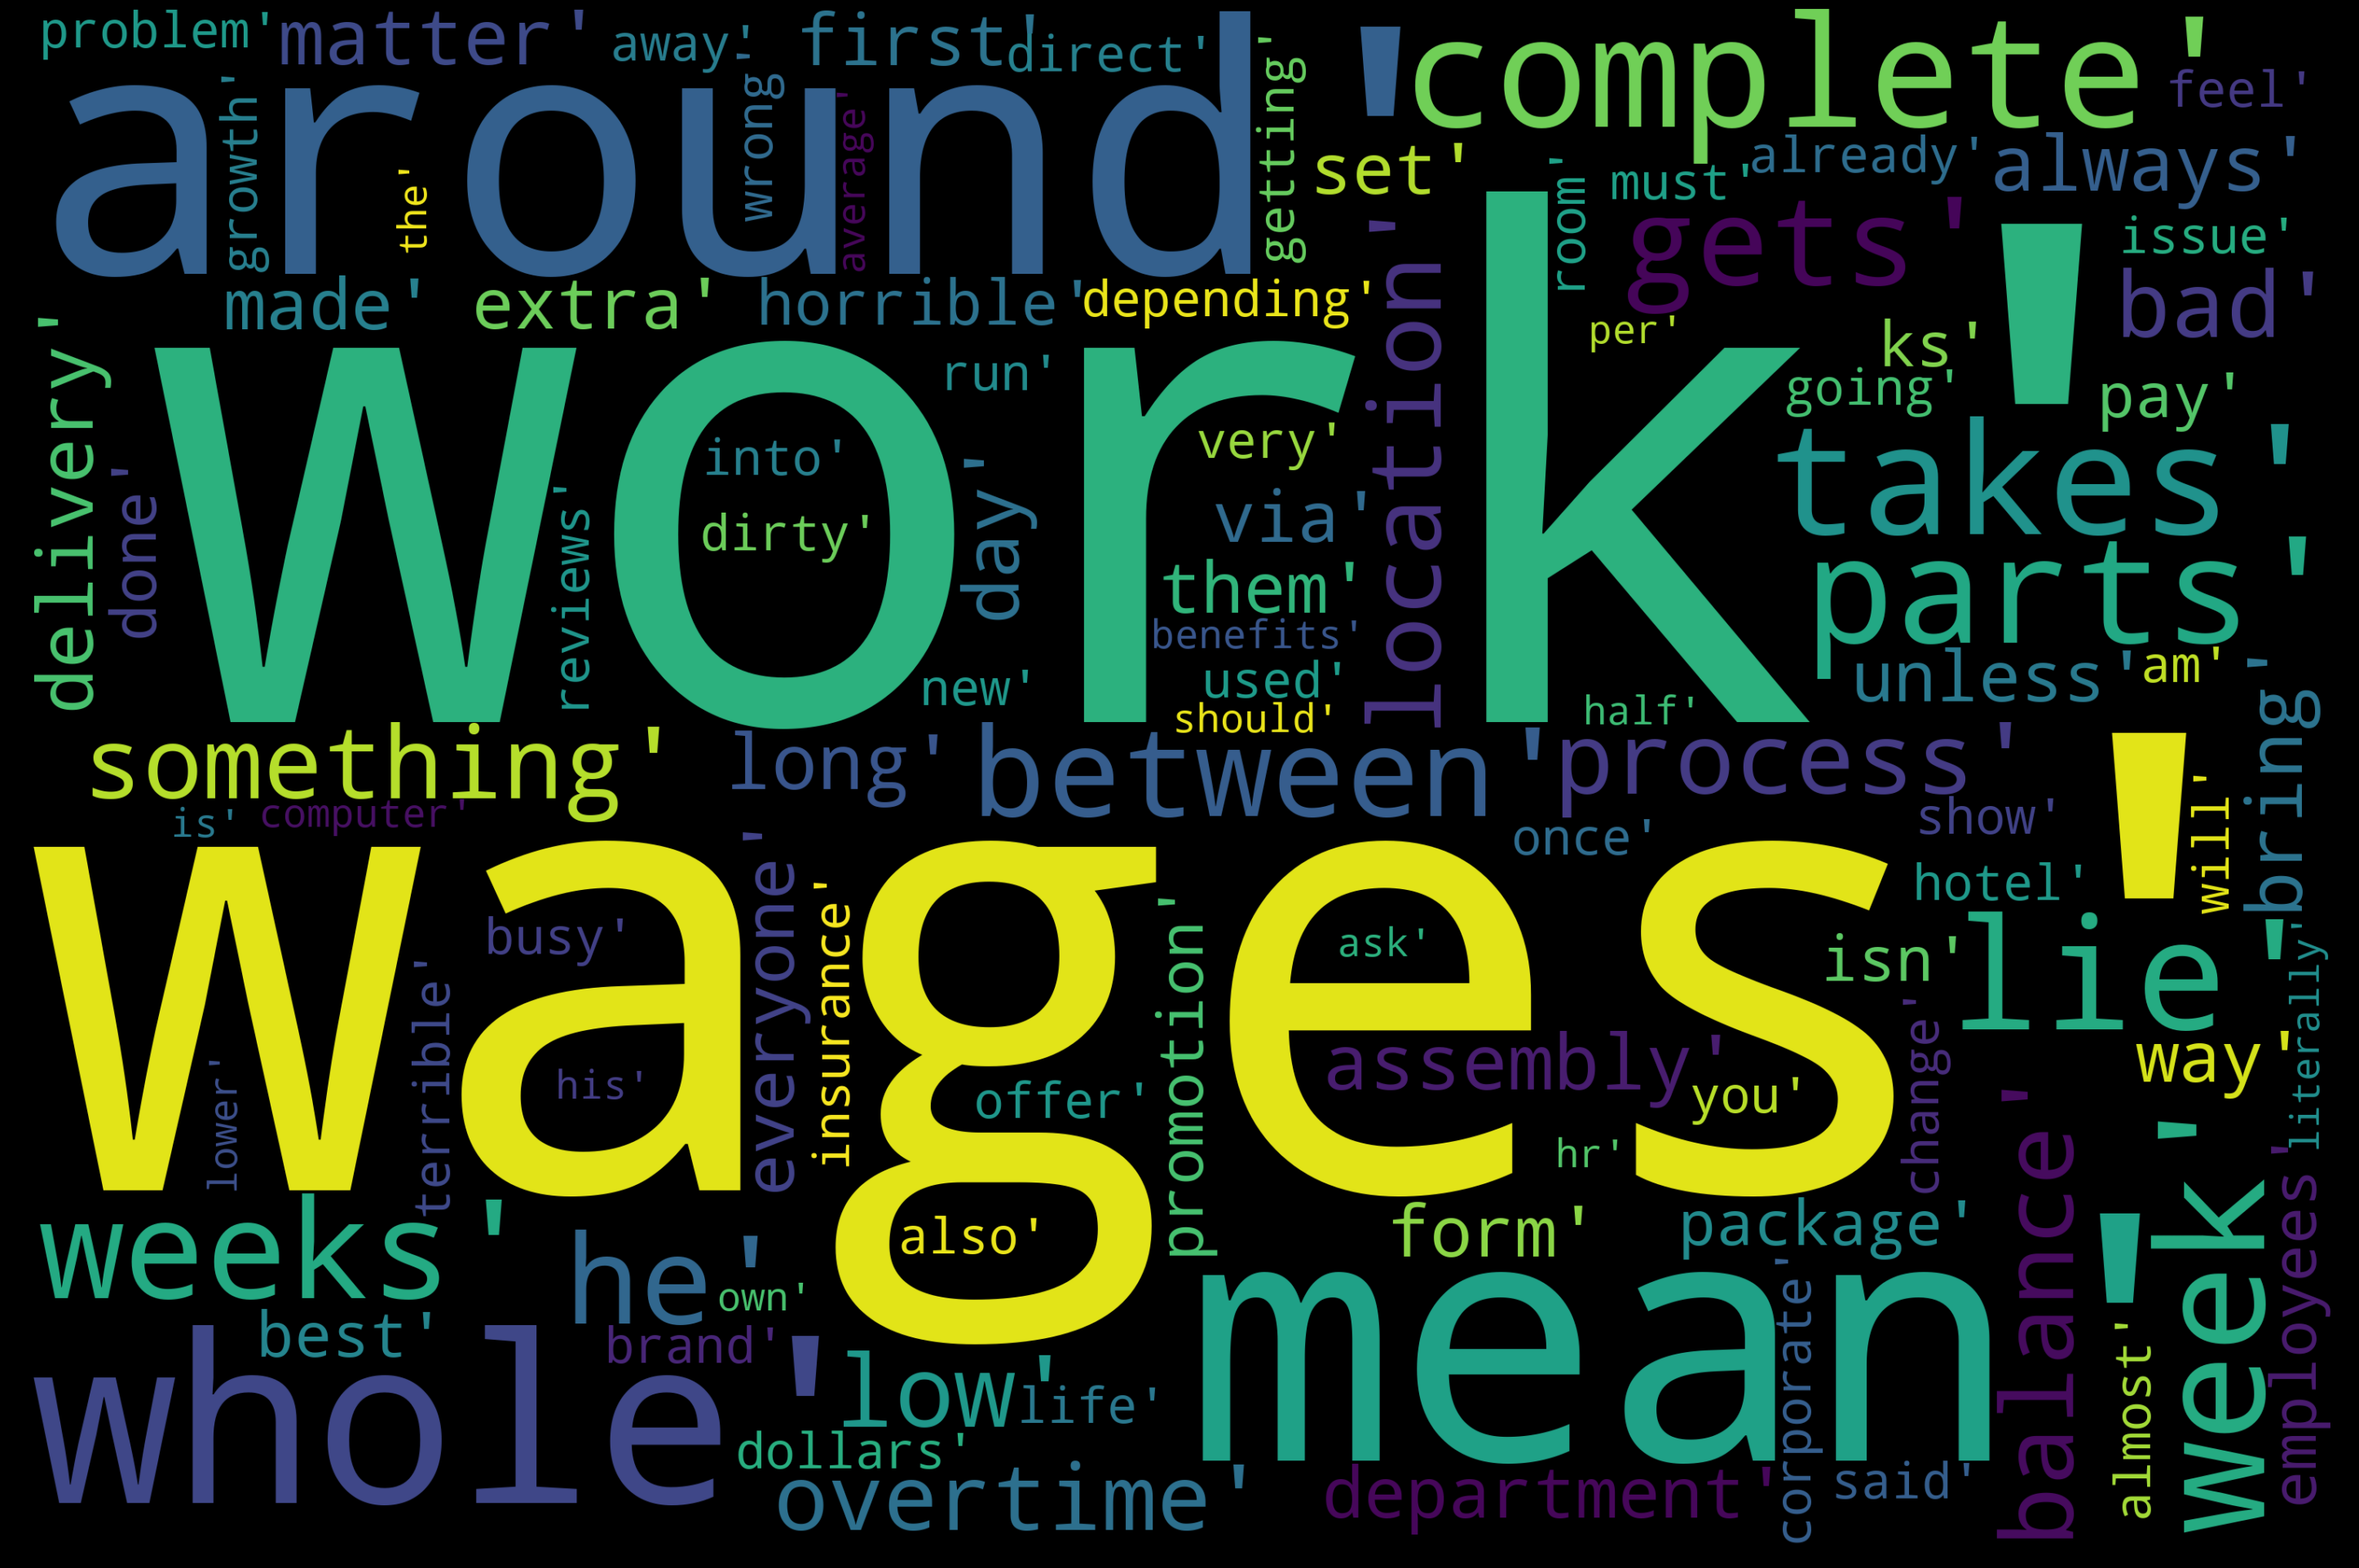

In [518]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num0'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
#plt.show()
plt.savefig('positive_1.jpg')

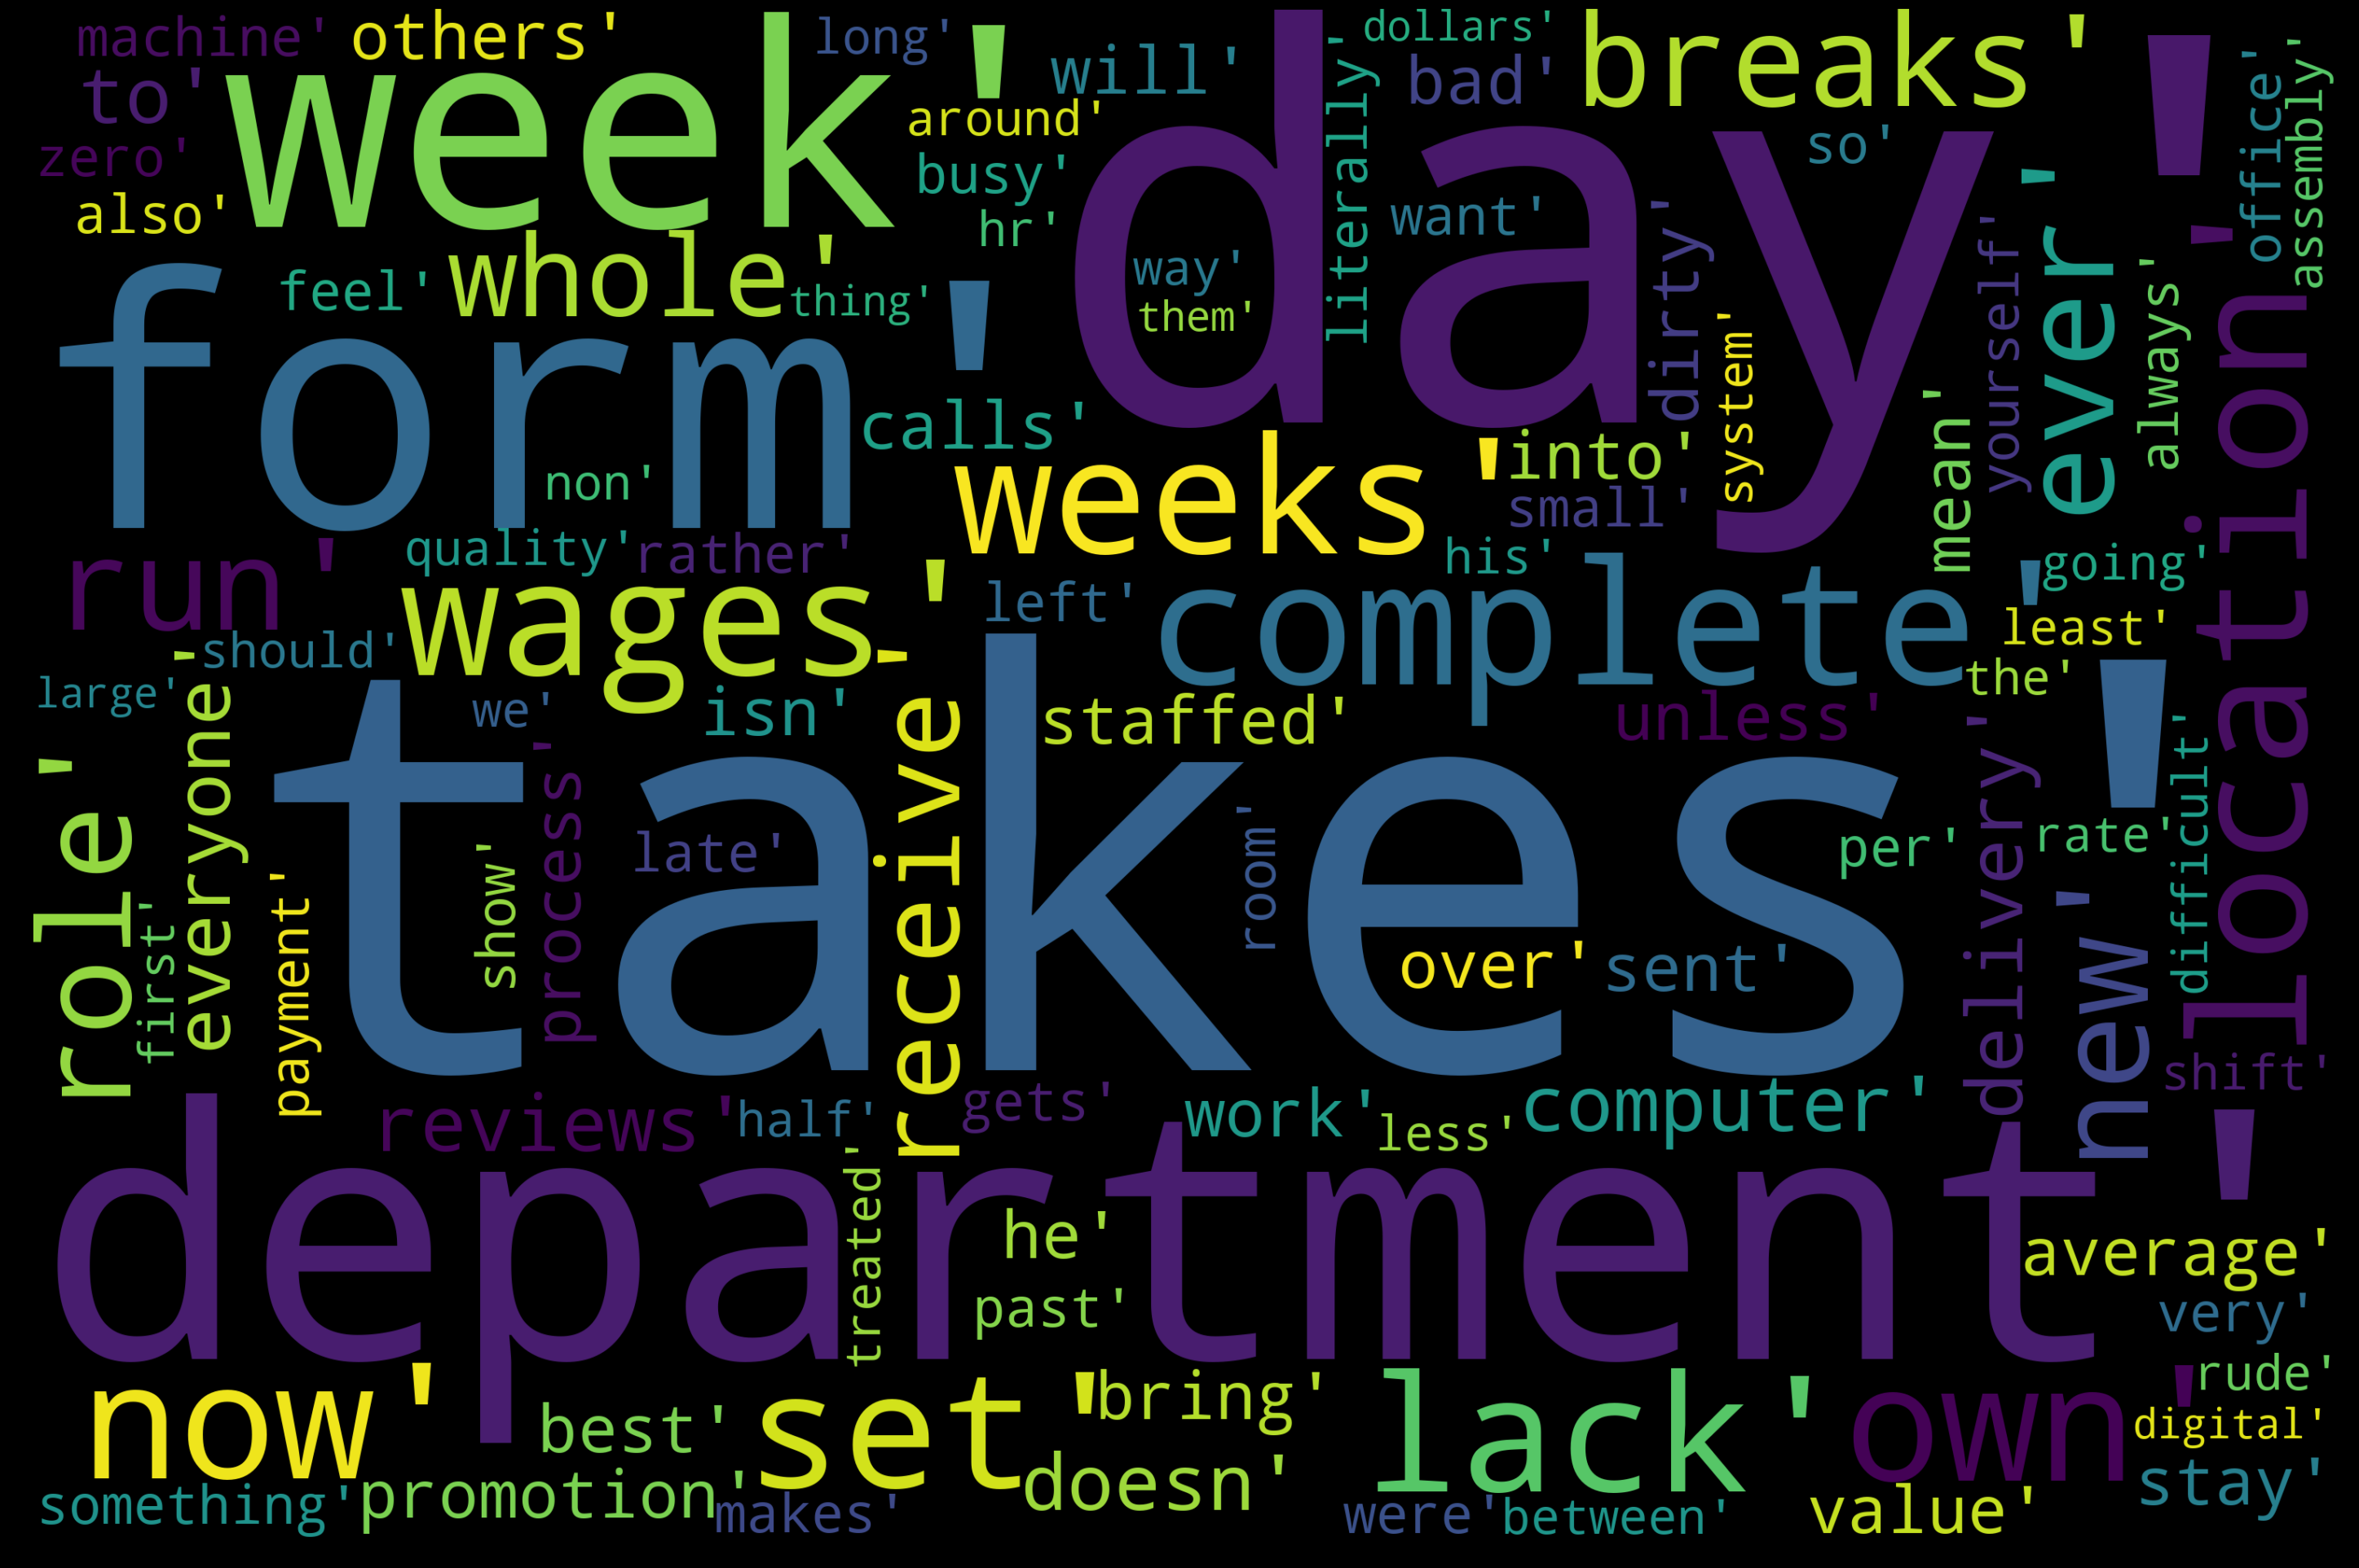

In [511]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num1'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num3'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
#plt.show()
plt.savefig('positive_2.jpg')

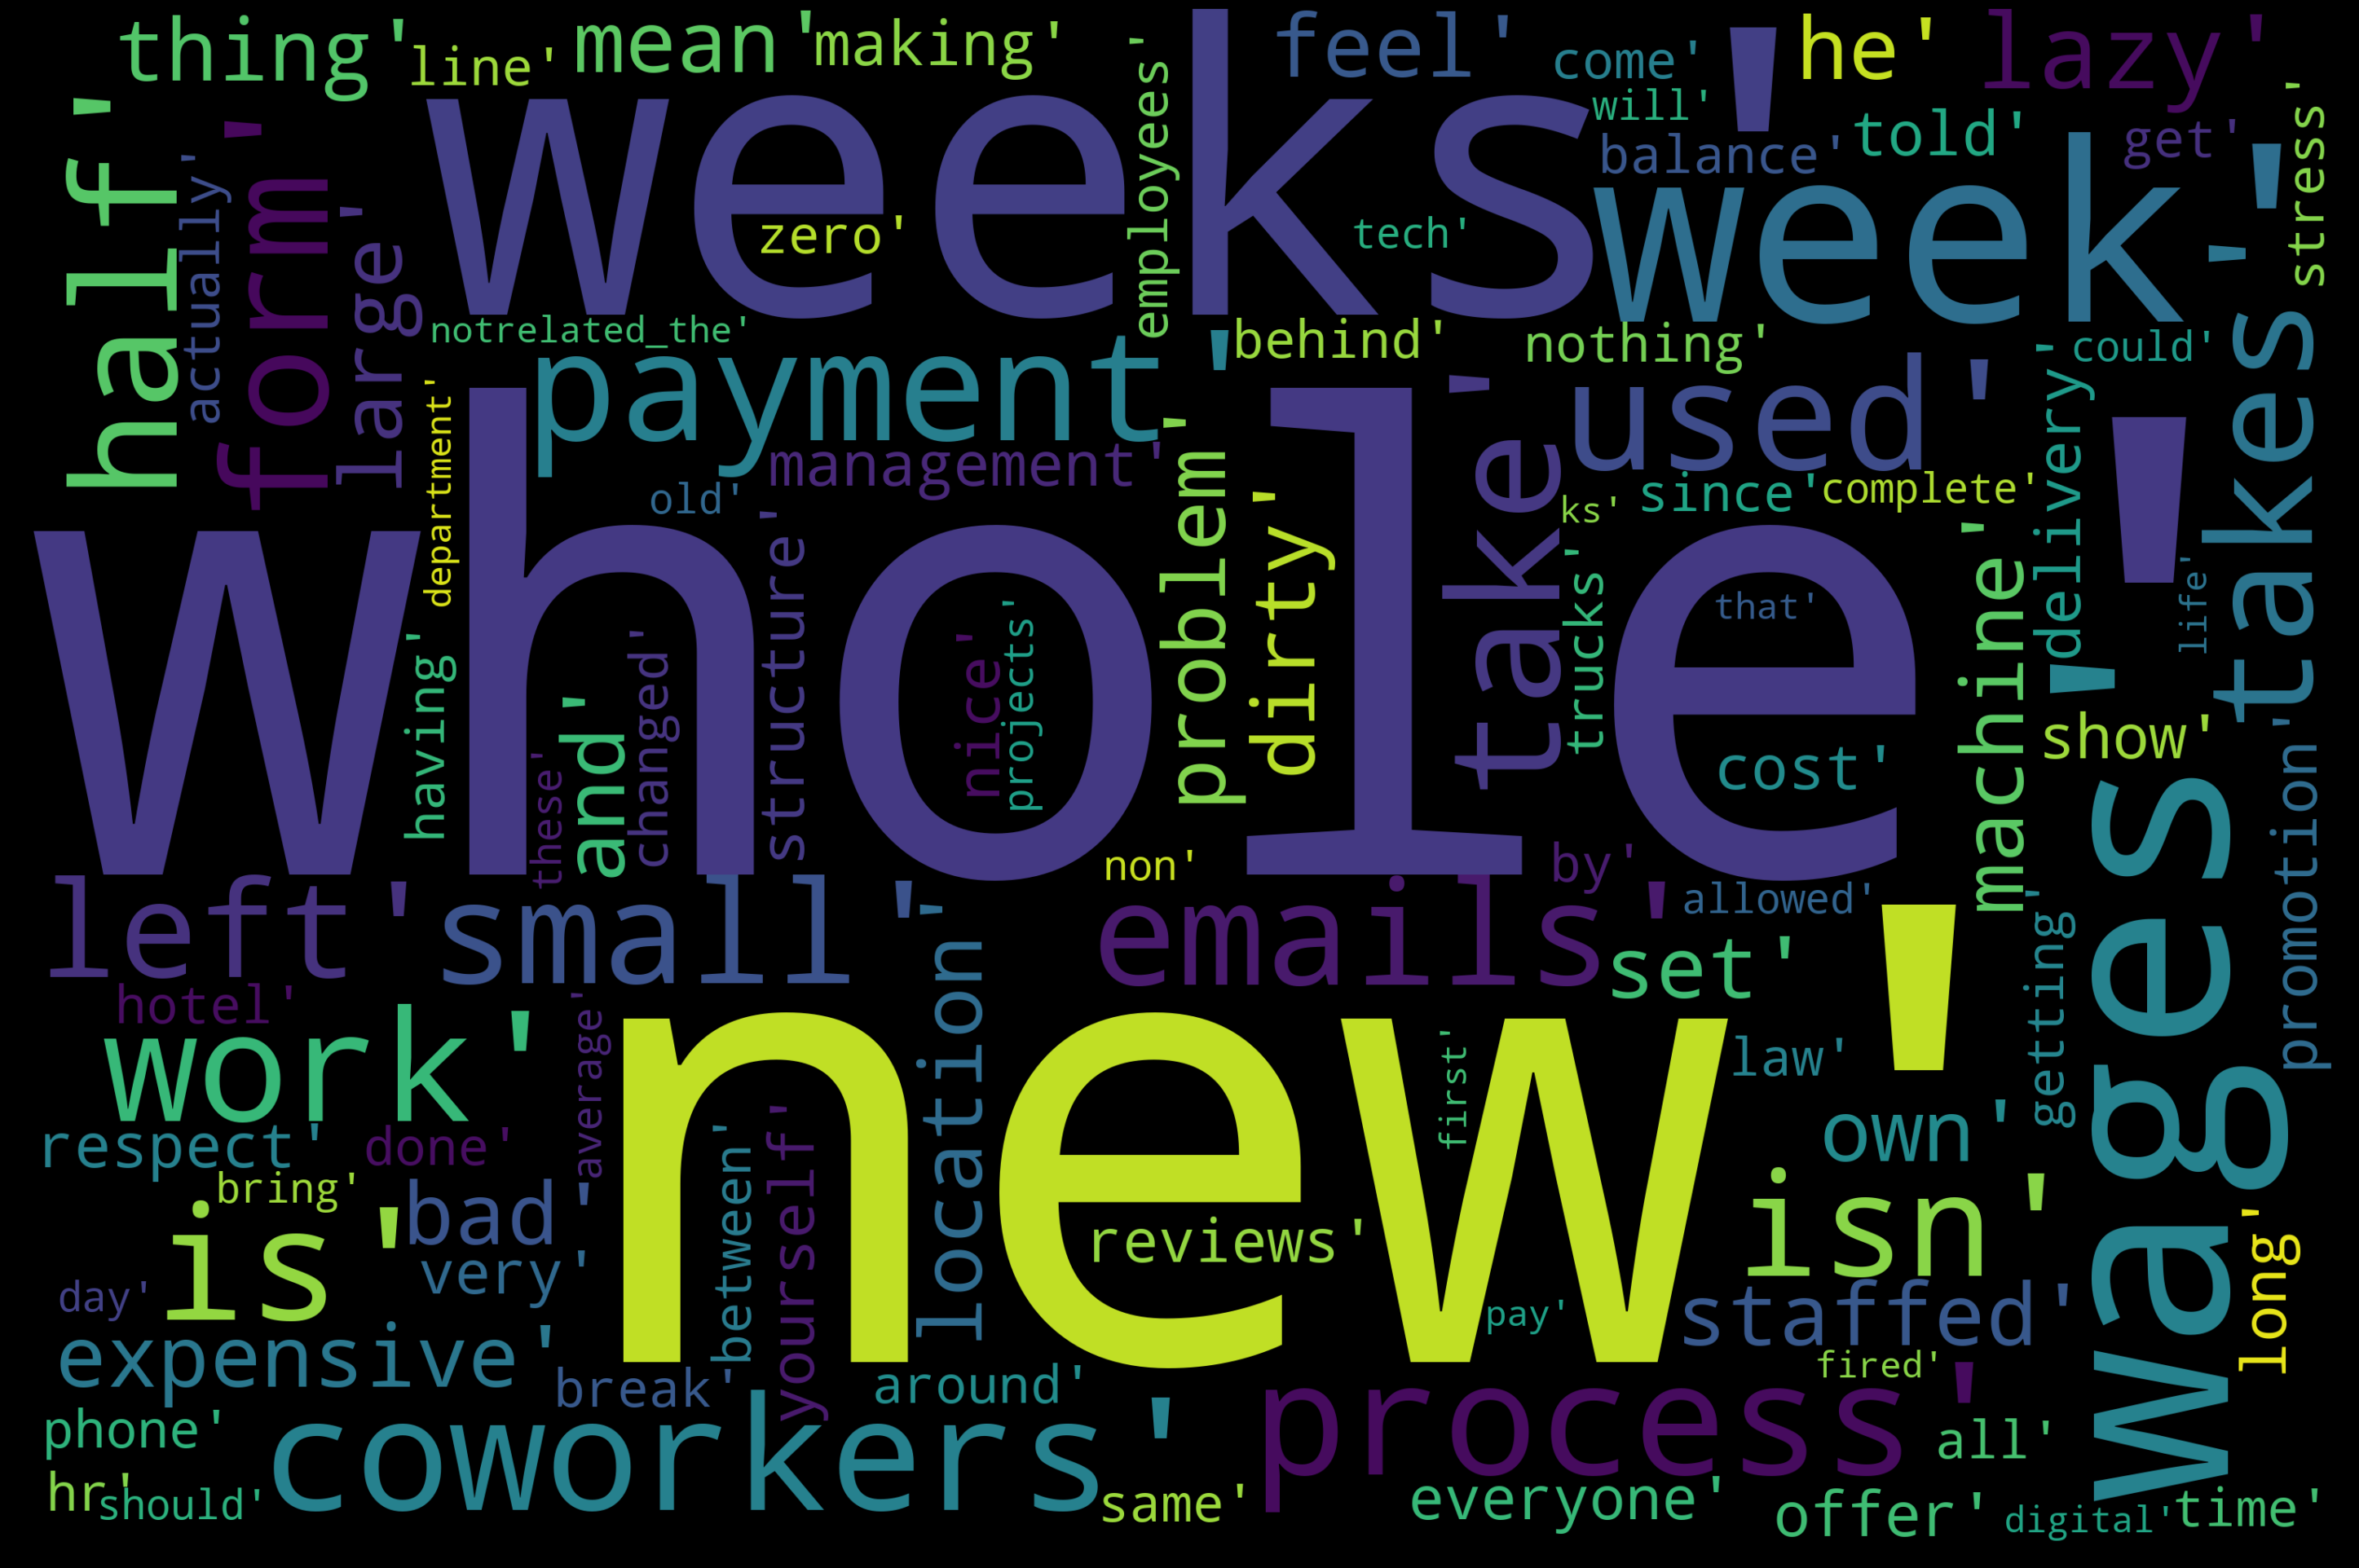

In [513]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num4'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

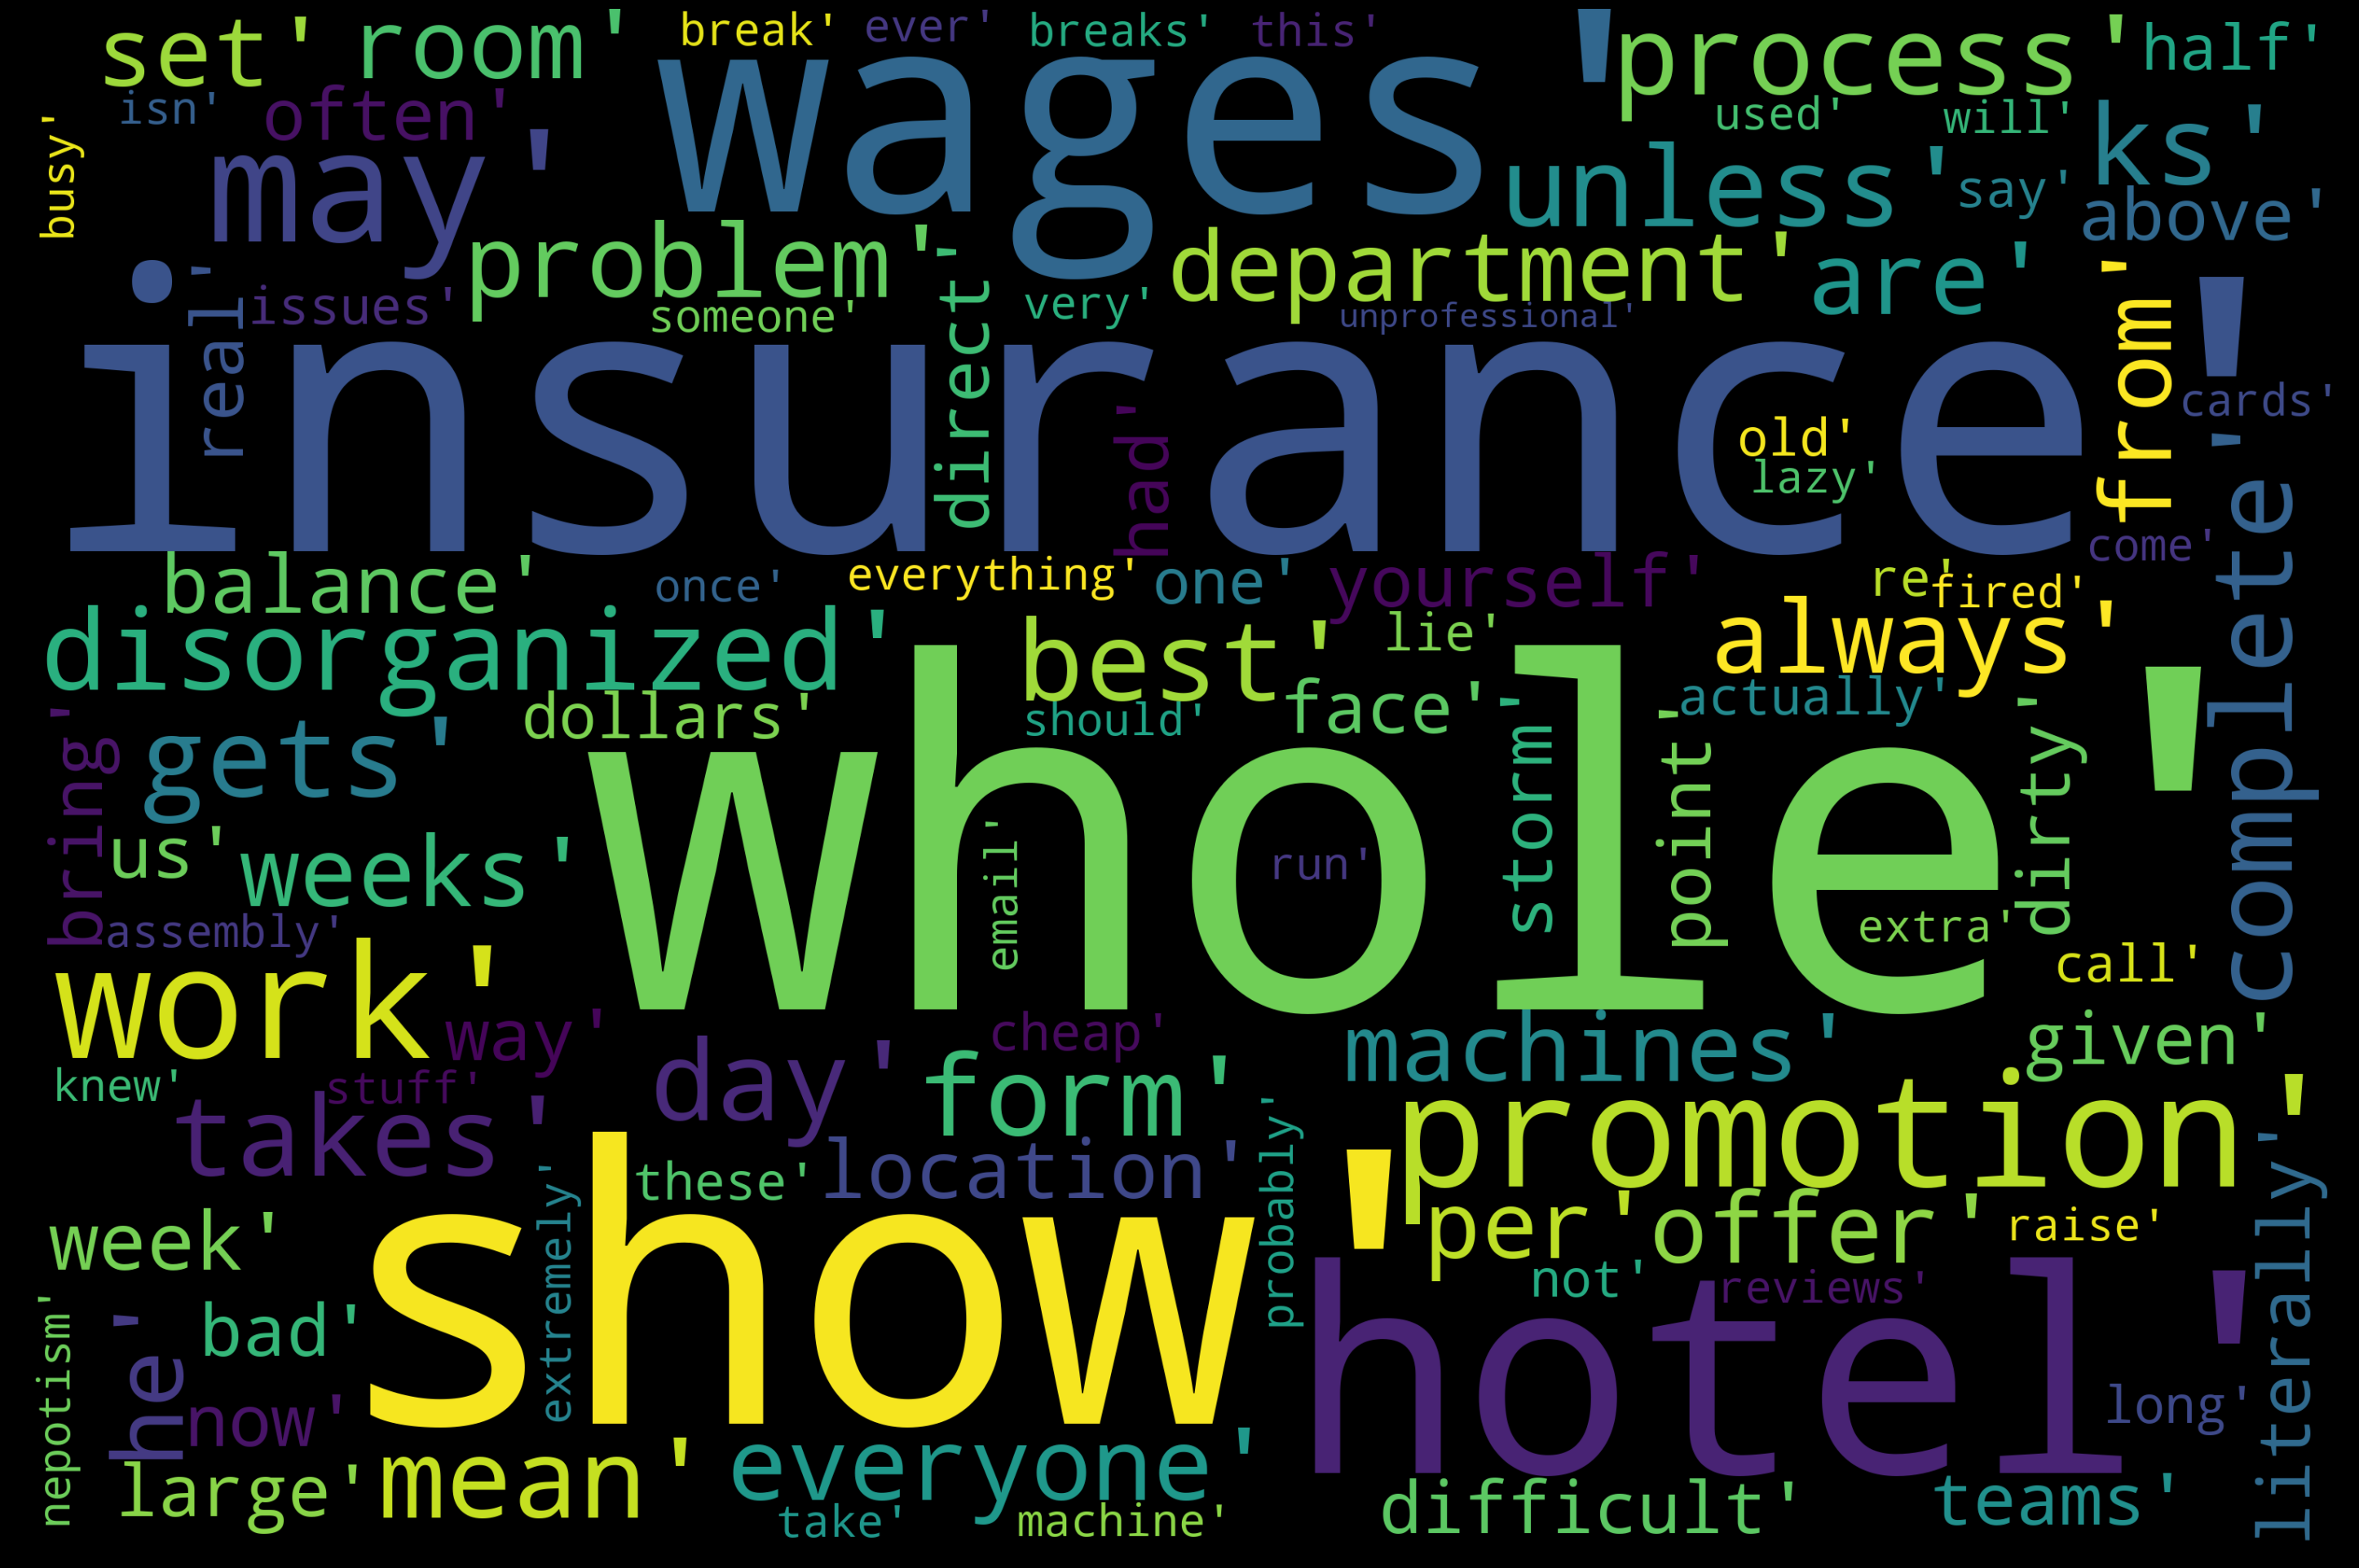

In [514]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num5'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()